### Moisés Salguero Morales. 
Carnet: 2017238398

### Andrés Jiménez Mora
Carnet: 2017106748

## Importación de librerías

En esta sección se importan las librerías que se utilizarán en el desarrollo del programa

In [69]:
%matplotlib inline
import gzip
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy
import numpy as np
import struct
import os
import random
import tensorflow as tf
import tensorflow.keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import MaxPooling2D, Dropout, Dense, Flatten
from keras.layers import Convolution2D as Conv2D
from tensorflow.keras import optimizers
from keras.optimizers import SGD
from random import sample
from six.moves import urllib
from keras.utils import np_utils



In [11]:
path="/Users/Dell/Desktop/ARCHIVOS/TEC/Semestre II-2021/Inteligencia Artificial/Tareas_Programadas/Tarea programada_3/EMNIST_DATASET/"

## Carga de datos 

In [ ]:
En esta sección se cargan los datos de la base de datos EMNIST, el archivo gzip fue descargado anteriormente
en la computadora.

In [12]:
 def leer_idx(filename):
        print("Procesando datos de %s." % filename)
        with gzip.open(filename,"rb") as f:
            #Lee el número mágico primero
            z,dtype,dim=struct.unpack(">HBB",f.read(4))
            print("Dimensiones: ", dim)
            #obtiene la forma de los datos
            shape=tuple(struct.unpack(">I",f.read(4))[0] for d in range(dim))
            print("Shape: ", shape)
            #devuelve los datos ordenados como un arreglo
            return np.frombuffer(f.read(),dtype=np.uint8).reshape(shape)

In [337]:
def load_emnist():
    #letras
    train_img=path+"emnist-letters-train-images-idx3-ubyte.gz"
    train_lbs=path+"emnist-letters-train-labels-idx1-ubyte.gz"
    test_img=path+"emnist-letters-test-images-idx3-ubyte.gz"
    test_lbs=path+"emnist-letters-test-labels-idx1-ubyte.gz"
    
    #numeros para la parte de análisis
    num_img=path+"emnist-digits-train-images-idx3-ubyte.gz"
    
    train_X=leer_idx(train_img)
    train_Y=leer_idx(train_lbs)
    test_X=leer_idx(test_img)
    test_Y=leer_idx(test_lbs)
    num_X=leer_idx(num_img)
    
    return train_X, train_Y, test_X, test_Y, num_X

In [338]:
raw_trainX, raw_trainY, raw_testX, raw_testY, raw_num_testX =load_emnist()

Procesando datos de /Users/Dell/Desktop/ARCHIVOS/TEC/Semestre II-2021/Inteligencia Artificial/Tareas_Programadas/Tarea programada_3/EMNIST_DATASET/emnist-letters-train-images-idx3-ubyte.gz.
Dimensiones:  3
Shape:  (124800, 28, 28)
Procesando datos de /Users/Dell/Desktop/ARCHIVOS/TEC/Semestre II-2021/Inteligencia Artificial/Tareas_Programadas/Tarea programada_3/EMNIST_DATASET/emnist-letters-train-labels-idx1-ubyte.gz.
Dimensiones:  1
Shape:  (124800,)
Procesando datos de /Users/Dell/Desktop/ARCHIVOS/TEC/Semestre II-2021/Inteligencia Artificial/Tareas_Programadas/Tarea programada_3/EMNIST_DATASET/emnist-letters-test-images-idx3-ubyte.gz.
Dimensiones:  3
Shape:  (20800, 28, 28)
Procesando datos de /Users/Dell/Desktop/ARCHIVOS/TEC/Semestre II-2021/Inteligencia Artificial/Tareas_Programadas/Tarea programada_3/EMNIST_DATASET/emnist-letters-test-labels-idx1-ubyte.gz.
Dimensiones:  1
Shape:  (20800,)
Procesando datos de /Users/Dell/Desktop/ARCHIVOS/TEC/Semestre II-2021/Inteligencia Artificial/

## Preparación de los datos 

En esta sección se definen 2 funciones utilizadas para generar los nuevos conjuntos de datos con base 
en la los datasets de EMNIST.

In [15]:
#Busca un número dentro de la lista dada, si está devuelve true y si no está devuelve false
def search_list(number,array):
    lgt=len(array)
    result=False
    for i in range(0,lgt):
        if (array[i]==number):
            result=True
    return result
 
#Para generar los nuevos conjuntos de datos, tiene como parámetros el límite superior: longitud del raw_Array, una lista 
#con el máximo número de cada letra, y los conjuntos con el raw data
def generateSets(limiteSup, limits_lista, raw_conjunto_X, raw_conjunto_Y):
    
    #Los nuevos conjuntos por llenar
    nuevo_conjunto_X=[]
    nuevo_conjunto_Y=[]
    
    #Array que almacena las posiciones anteriormente usadas
    used_random=[]
    
    #Estado de la generación de los nuevos conjuntos
    complete=False

    while(complete==False):
        int_lb=0
        int_data=0

        if (np.all(limits_lista == 0)):
            complete=True
        else:
            rand_Num=random.randint(0,limiteSup-1)

            if (search_list(rand_Num,used_random)==False):

                #Verifica que se puedan agregar los datos a los conjuntos finales
                int_data=raw_conjunto_X[rand_Num]
                int_lb=raw_conjunto_Y[rand_Num]
                
                if(limits_lista[int_lb-1]>0):

                    #Actualiza la cantidad de letras 
                    limits_lista[int_lb-1]=limits_lista[int_lb-1]-1
                    
                    #Normaliza los datos
                    int_data=int_data/255
                                    
                    #Actualiza los conjuntos de datos procesados
                    nuevo_conjunto_X.append(int_data)
                    nuevo_conjunto_Y.append(int_lb)
                    
                    
                    
                    
                #Actualiza lista de números random usados
                used_random.append(rand_Num)

    return nuevo_conjunto_X, nuevo_conjunto_Y 

## Definición del modelo convolucional 

En esta sección se define una función del modelo convolucional, en el que la cantidad de nucleos es variable dependiendo de lo que desee el usuario, esto se pone como un parámetro de entrada. Se puede utilizar una capa densa si el usuario lo requiere. 

In [42]:
# definición de una función que contiene el modelo 

def definicionModelo(nucleos, densidad):

    model = Sequential()  # se define como un modelo secuencial

    # entrada de 28x 28 de 1 canal
    # "Nuecleos" es la cantidad de filtros convolucionales de 5x5
    model.add(Conv2D(nucleos, (5,5), activation = 'relu', input_shape= (28, 28, 1)))
    # realización del maxpooling, se reduce en un factor de 2 las matrices
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))  # capa de dropout
    model.add(Flatten())
    # si se requiere la capa de densidad se usa "TRUE" como parámetro de entrada
    if (densidad):
        model.add(Dense(100, activation= 'relu'))
    model.add(Dense(27, activation = 'softmax')) # capa de salida
     
    # Definición del modelo con sus características
    model.compile(loss= 'categorical_crossentropy',
             optimizer= SGD(lr=0.01, decay=1e-6, momentum= 0.5, nesterov= True), metrics=['accuracy'])
    
    return model

## Generación de los nuevos conjuntos de datos

En esta sección se definen arrays importantes y se hacen llamadas a las funciones para generar los nuevos conjuntos de train y test

In [340]:
#Se generan arrays para llevar el conteo de cada letra ingresada a los nuevos conjuntos
limits_train=np.array([100 for _ in range(26)]) #100 espacios para cada letra
limits_test=np.array([60 for _ in range(26)]) #60 espacios para cada letra

#Nuevos conjuntos para training y testing
pros_train_X=[]
pros_train_Y=[]
pros_test_X=[]
pros_test_Y=[]

pros_train_X, pros_train_Y = generateSets(124799, limits_train, raw_trainX, raw_trainY)

pros_train_X=numpy.array(pros_train_X)
pros_train_Y=numpy.array(pros_train_Y)


# Reshape data 
pros_train_X = pros_train_X.reshape(pros_train_X.shape[0], 28, 28, 1).astype('float32')
pros_train_Y = np_utils.to_categorical(pros_train_Y)



print("Nuevos Conjuntos de training listos")
print("Dimension de pros_train_X: "+str(len(pros_train_X)))
print("Dimension de pros_train_Y: "+str(len(pros_train_Y)))

pros_test_X, pros_test_Y = generateSets(20799, limits_test, raw_testX, raw_testY)

pros_test_X=numpy.array(pros_test_X)
pros_test_Y=numpy.array(pros_test_Y)

# Reshape data 
pros_test_X = pros_test_X.reshape(pros_test_X.shape[0], 28, 28, 1).astype('float32')
pros_test_Y = np_utils.to_categorical(pros_test_Y)

print("Nuevos Conjuntos de testing listos")
print("Dimension de pros_test_X: "+str(len(pros_test_X)))
print("Dimension de pros_test_Y: "+str(len(pros_test_Y)))

#Tratamiento de las imágenes de números escritos a mano
raw_num_testX = raw_num_testX.reshape(raw_num_testX.shape[0], 28, 28, 1).astype('float32')
raw_num_testX= raw_num_testX/255

print("Conjunto de números listo")


Nuevos Conjuntos de training listos
Dimension de pros_train_X: 2600
Dimension de pros_train_Y: 2600
Nuevos Conjuntos de testing listos
Dimension de pros_test_X: 1560
Dimension de pros_test_Y: 1560
Conjunto de números listo


### Red con 8 núcleos en su primera capa de convolucion

Acá se llama a la función "definicionModelo" que es la encargada de definir el modelo de red que se quiera. Como parámetros de entrada está la cantidad de núcleso, los cuales son 8 en este caso y no se requiere de capa densa. 

In [21]:
model = definicionModelo(8,False)
history=model.fit(pros_train_X, pros_train_Y, batch_size=128, epochs=100, validation_data=(pros_test_X, pros_test_Y))

Epoch 1/100
21/21 [==============================] - 1s 54ms/step - loss: 3.3054 - accuracy: 0.0446 - val_loss: 3.2655 - val_accuracy: 0.0840
Epoch 2/100
21/21 [==============================] - 1s 36ms/step - loss: 3.2689 - accuracy: 0.0623 - val_loss: 3.2281 - val_accuracy: 0.1160
Epoch 3/100
21/21 [==============================] - 1s 35ms/step - loss: 3.2194 - accuracy: 0.0900 - val_loss: 3.1618 - val_accuracy: 0.1641
Epoch 4/100
21/21 [==============================] - 1s 34ms/step - loss: 3.1453 - accuracy: 0.1069 - val_loss: 3.0448 - val_accuracy: 0.2205
Epoch 5/100
21/21 [==============================] - 1s 35ms/step - loss: 3.0198 - accuracy: 0.1592 - val_loss: 2.8560 - val_accuracy: 0.3090
Epoch 6/100
21/21 [==============================] - 1s 35ms/step - loss: 2.8822 - accuracy: 0.1977 - val_loss: 2.6239 - val_accuracy: 0.3968
Epoch 7/100
21/21 [==============================] - 1s 35ms/step - loss: 2.6429 - accuracy: 0.2496 - val_loss: 2.3433 - val_accuracy: 0.4622
Epoch 

Para obtener una mejor visualización de los resultados, se realizarán gráficas de la precisión y las pérdidas del modelo utilizado, las cuales se observan a continuaciónñ. 

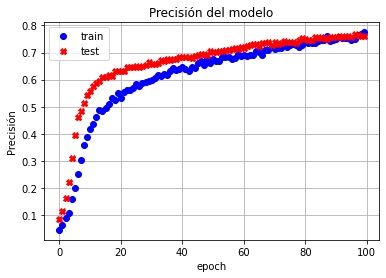

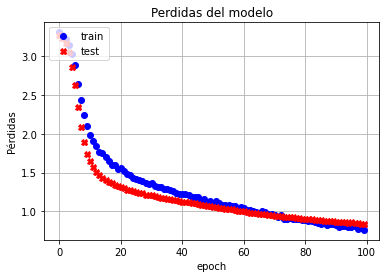

In [22]:
# Impresión de las curvas de precisión y péridas según número de iteraciones

plt.plot(history.history['accuracy'],'bo')
plt.plot(history.history['val_accuracy'],'rX')
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

#Perdidas
plt.plot(history.history['loss'],'bo')
plt.plot(history.history['val_loss'],'rX')
plt.title('Perdidas del modelo')
plt.ylabel('Pérdidas')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

### CNN con 16 núcleos en su primera capa de procesado. 

Se probará ahora la misma ren neuronal de convolución pero ahora con 16 núcleos o kernels en su primera capa de procesado. De esta manera ahora se llama a la función "definicionmodelo" pero ahora como parámetro de núcelo se colocará un 16 en vez de un 8. 

In [23]:
model2 = definicionModelo(16,False)
history2=model2.fit(pros_train_X, pros_train_Y, batch_size=128, epochs=100, validation_data=(pros_test_X, pros_test_Y))

Epoch 1/100
21/21 [==============================] - 1s 59ms/step - loss: 3.2856 - accuracy: 0.0612 - val_loss: 3.2199 - val_accuracy: 0.0994
Epoch 2/100
21/21 [==============================] - 1s 52ms/step - loss: 3.1865 - accuracy: 0.1008 - val_loss: 3.1021 - val_accuracy: 0.2090
Epoch 3/100
21/21 [==============================] - 1s 44ms/step - loss: 3.0538 - accuracy: 0.1546 - val_loss: 2.9074 - val_accuracy: 0.3417
Epoch 4/100
21/21 [==============================] - 1s 43ms/step - loss: 2.8241 - accuracy: 0.2419 - val_loss: 2.6011 - val_accuracy: 0.4410
Epoch 5/100
21/21 [==============================] - 1s 43ms/step - loss: 2.5387 - accuracy: 0.3238 - val_loss: 2.2374 - val_accuracy: 0.5186
Epoch 6/100
21/21 [==============================] - 1s 45ms/step - loss: 2.2568 - accuracy: 0.3773 - val_loss: 1.9442 - val_accuracy: 0.5263
Epoch 7/100
21/21 [==============================] - 1s 44ms/step - loss: 2.0402 - accuracy: 0.4342 - val_loss: 1.7380 - val_accuracy: 0.5615
Epoch 

Y de igual manera se realizará la graficación para tener una mejor visualización de los resultados.

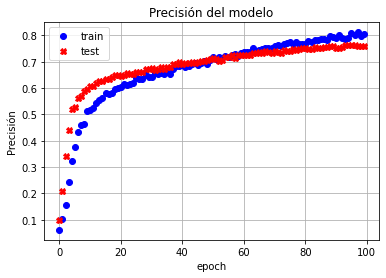

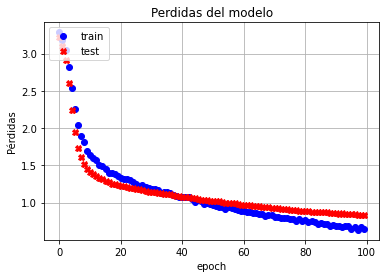

In [25]:
# Impresión de las curvas de precisión y péridas según número de iteraciones

plt.plot(history2.history['accuracy'],'bo')
plt.plot(history2.history['val_accuracy'],'rX')
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

#Perdidas
plt.plot(history2.history['loss'],'bo')
plt.plot(history2.history['val_loss'],'rX')
plt.title('Perdidas del modelo')
plt.ylabel('Pérdidas')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

### CNN con 24 núcleos en su primera capa de procesado

Ahora se realizarán pruebas con la misma red pero con 24 núcleos en su primera capa de procesado. 

In [26]:
model3 = definicionModelo(24,False)
history3=model3.fit(pros_train_X, pros_train_Y, batch_size=128, epochs=100, validation_data=(pros_test_X, pros_test_Y))

Epoch 1/100
21/21 [==============================] - 1s 71ms/step - loss: 3.2545 - accuracy: 0.0677 - val_loss: 3.1778 - val_accuracy: 0.1269
Epoch 2/100
21/21 [==============================] - 1s 59ms/step - loss: 3.1281 - accuracy: 0.1188 - val_loss: 3.0032 - val_accuracy: 0.2481
Epoch 3/100
21/21 [==============================] - 1s 56ms/step - loss: 2.9212 - accuracy: 0.2096 - val_loss: 2.7064 - val_accuracy: 0.4147
Epoch 4/100
21/21 [==============================] - 1s 61ms/step - loss: 2.6048 - accuracy: 0.3173 - val_loss: 2.3140 - val_accuracy: 0.4750
Epoch 5/100
21/21 [==============================] - 1s 56ms/step - loss: 2.2617 - accuracy: 0.3796 - val_loss: 1.9518 - val_accuracy: 0.5333
Epoch 6/100
21/21 [==============================] - 1s 58ms/step - loss: 1.9662 - accuracy: 0.4546 - val_loss: 1.7052 - val_accuracy: 0.5647
Epoch 7/100
21/21 [==============================] - 1s 57ms/step - loss: 1.8061 - accuracy: 0.4796 - val_loss: 1.6008 - val_accuracy: 0.5436
Epoch 

Y las gráficas de precisión y pérdidas se muestran a continuación 

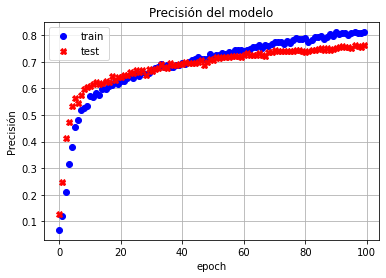

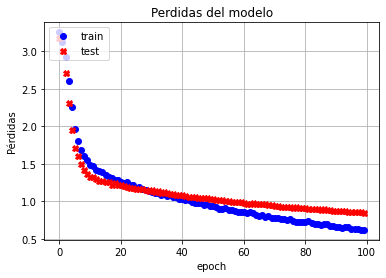

In [27]:
# Impresión de las curvas de precisión y péridas según número de iteraciones

plt.plot(history3.history['accuracy'],'bo')
plt.plot(history3.history['val_accuracy'],'rX')
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

#Perdidas
plt.plot(history3.history['loss'],'bo')
plt.plot(history3.history['val_loss'],'rX')
plt.title('Perdidas del modelo')
plt.ylabel('Pérdidas')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

### Con una capa densa 

Para la selección de los hiperparámetros se consideraron los siguientes factores: el número de kernels en la entrada es de 24 ya que fue el que dió los mejores resultados en la sección anterior; se mantienen 100 iteraciones ya que dicho número dió buenos resultados resultados con base en las pruebas anteriores. Además, se setean 1 kernels en la capa densa, con base en referencias recopiladas en nuestra investigación para realizar la tarea.

In [43]:
model4 = definicionModelo(24,True)
history4=model4.fit(pros_train_X, pros_train_Y, batch_size=26, epochs=100, validation_data=(pros_test_X, pros_test_Y))

Epoch 1/100
100/100 [==============================] - 2s 17ms/step - loss: 3.1820 - accuracy: 0.0954 - val_loss: 2.8111 - val_accuracy: 0.3141
Epoch 2/100
100/100 [==============================] - 1s 15ms/step - loss: 2.3082 - accuracy: 0.3488 - val_loss: 1.6694 - val_accuracy: 0.5192
Epoch 3/100
100/100 [==============================] - 2s 15ms/step - loss: 1.7035 - accuracy: 0.4992 - val_loss: 1.4722 - val_accuracy: 0.5590
Epoch 4/100
100/100 [==============================] - 2s 16ms/step - loss: 1.5027 - accuracy: 0.5531 - val_loss: 1.3201 - val_accuracy: 0.6160
Epoch 5/100
100/100 [==============================] - 2s 15ms/step - loss: 1.3769 - accuracy: 0.5923 - val_loss: 1.2300 - val_accuracy: 0.6288
Epoch 6/100
100/100 [==============================] - 2s 15ms/step - loss: 1.2869 - accuracy: 0.6085 - val_loss: 1.1729 - val_accuracy: 0.6667
Epoch 7/100
100/100 [==============================] - 2s 15ms/step - loss: 1.1949 - accuracy: 0.6500 - val_loss: 1.1139 - val_accuracy:

Ahora con esta capa, se puede observar las gráficas de pérdida y precisión.

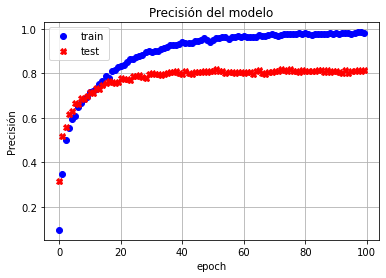

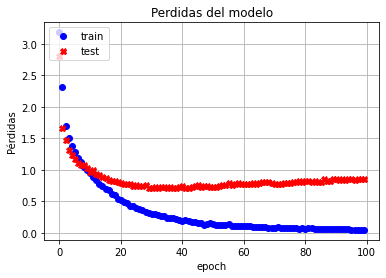

In [44]:
# Impresión de las curvas de precisión y péridas según número de iteraciones

plt.plot(history4.history['accuracy'],'bo')
plt.plot(history4.history['val_accuracy'],'rX')
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

#Perdidas
plt.plot(history4.history['loss'],'bo')
plt.plot(history4.history['val_loss'],'rX')
plt.title('Perdidas del modelo')
plt.ylabel('Pérdidas')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

## Análisis de resultados 

### ¿Cuál fue la mejor red? 

Con base en los resultados encontrados, la red que presentó un mejor desempeño fue la red densa (98.35 % precisión 
para training y 81.22 % precisión para testing) con 24 kernels en la entrada, 100 en la capa densa y 27 a la salida. 
La función relu fue utilizada en todas las pruebas así como el gradiente descendiente. Sin embargo, se presentó la 
peculiaridad de que el training fue más preciso que el testing en casi un 20%. Esto se puede deber a que las imagenes disponibles para el testing difieren mucho del conjunto usado para training y por lo tanto, la red no es capaz de reconocer del
todo, nuevos trazos en las letras o nuevos formas, por ejemplo.

### Función de los kernels en la red convolucional 

Primeramente, se realizará un código para extraer los feature maps que genera nuestra CNN, en este caso, se mostrarán únicamente los mapas de activación de los 24 kernels de la capa de entrada

In [334]:
#se extraen los nombres de cada una de las capas
layer_names = [layer.name for layer in model4.layers]

In [46]:
print(layer_names)

['conv2d_9', 'max_pooling2d_9', 'dropout_9', 'flatten_8', 'dense_14', 'dense_15']


In [47]:
#para visualizar los layers del modelo
model.layers

In [48]:
#se guardan las salidas y sus shape para cada layer, esto para el model4 que corresponde a la capa densa
layer_outputs = [layer.output for layer in model4.layers]

In [49]:
print(layer_outputs)

[<tf.Tensor 'conv2d_9/Relu:0' shape=(None, 24, 24, 24) dtype=float32>, <tf.Tensor 'max_pooling2d_9/MaxPool:0' shape=(None, 12, 12, 24) dtype=float32>, <tf.Tensor 'dropout_9/cond/Identity:0' shape=(None, 12, 12, 24) dtype=float32>, <tf.Tensor 'flatten_8/Reshape:0' shape=(None, 3456) dtype=float32>, <tf.Tensor 'dense_14/Relu:0' shape=(None, 100) dtype=float32>, <tf.Tensor 'dense_15/Softmax:0' shape=(None, 27) dtype=float32>]


In [59]:
#para obtener los mapas de activación de nuestro modelo
feature_map_model = tf.keras.models.Model(inputs=model4.input, outputs=layer_outputs)

In [328]:
#se introduce una imagen tomada de los datos de testing
feature_maps = feature_map_model.predict(pros_test_X[245].T)

In [329]:
for layer_name, feature_map in zip(layer_names, feature_maps):print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

The shape of the conv2d_9 is =======>> (1, 24, 24, 24)
The shape of the max_pooling2d_9 is =======>> (1, 12, 12, 24)
The shape of the dropout_9 is =======>> (1, 12, 12, 24)
The shape of the flatten_8 is =======>> (1, 3456)
The shape of the dense_14 is =======>> (1, 100)
The shape of the dense_15 is =======>> (1, 27)


In [333]:
#se imprimen los mapas de activación según la entrada dada
square = 8
for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    #show the figure
    pyplot.show()

Se realizó el procedimiento anterior para varias letras, a continuación se puede observar el efecto de los 24 kernels en la capa de entrada, para una muestra de 14 letras.

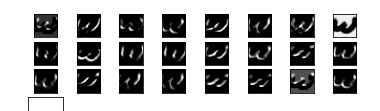

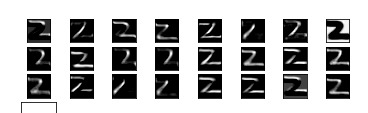

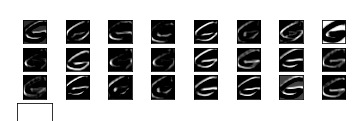

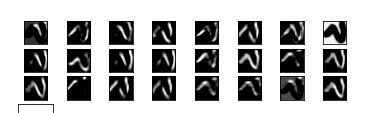

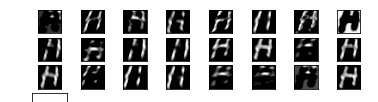

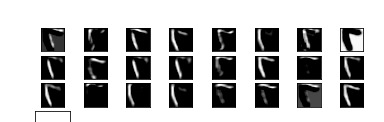

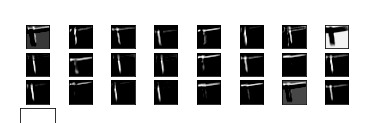

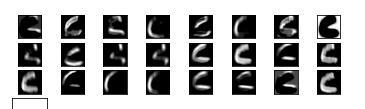

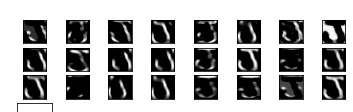

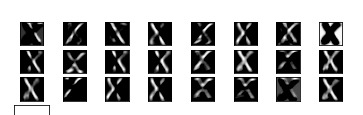

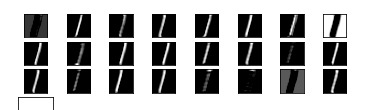

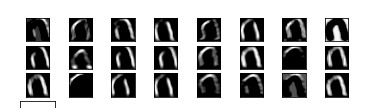

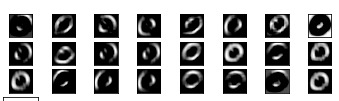

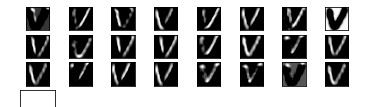

#### Planteamiento de una hipótesis respecto a los mapas de activación 

Analizando cuidadosamente los mapas de activación, se pueden notar ciertas generalidades. Para empezar, a excepción de los kernels 1, 8, 18 y 23, el resto tiende a distinguir partes del contorno de la letra, el kernel 14 tiende a identificar la letra casi en su totalidad, sin embargo, se podría decir que cumplen funciones casi indistinguigles entre sí. Para el caso de los kernels 1, 18 y 23, estos distinguen rasgos más propios de la transición entre la letra y el fondo. Para el caso del kernel 8, este tiende a identificar el fondo de la imagen, todo espacio donde no hayan trazos de letras, por esta razón se pueden notar los colores invertidos.

#### Convolución de imágenes de naturaleza distinta (cifras) 

A continuación, se convolucionan ciertas cifras escritas a mano y se obtienen los mapas de activación generados por los kernels de la capa de entrada

In [365]:
#se introduce una imagen tomada de los datos de testing
feature_maps = feature_map_model.predict(raw_num_testX[256].T)

In [366]:
for layer_name, feature_map in zip(layer_names, feature_maps):print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

The shape of the conv2d_9 is =======>> (1, 24, 24, 24)
The shape of the max_pooling2d_9 is =======>> (1, 12, 12, 24)
The shape of the dropout_9 is =======>> (1, 12, 12, 24)
The shape of the flatten_8 is =======>> (1, 3456)
The shape of the dense_14 is =======>> (1, 100)
The shape of the dense_15 is =======>> (1, 27)


In [ ]:
#se imprimen los mapas de activación según la entrada dada
square = 8
for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    #show the figure
    pyplot.show()

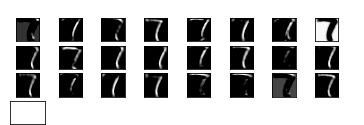

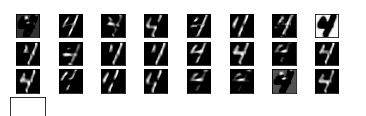

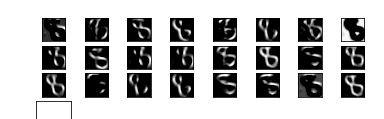

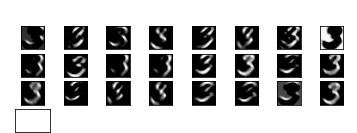

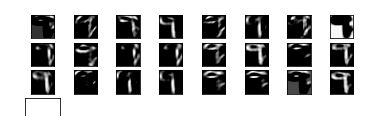

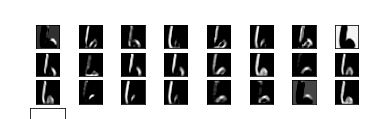

De los mapas de activación anterior, se puede comprobar el comportamiento sugerido en la hipótesis planteada anteriormente. La mayoría de kernels identifican partes del contorno de la cifra, el kernel 14 tiende a identificar la totalidad de la cifra. El kernel 8 invierte los colores para distinguir el fondo de la imagen. También los kernel 1, 18 y 23 muestran características relacionadas con el sombreo, tal y como se explico en la tesis planteada para los mapas de activación de las letras.

### Respuestas a preguntas

### 1. ¿Entre más kernels se aplique es mejor la precisión del modelo?

Entre mayor número de Kernels o filtros tenga la red se va a ver una mejoría, debido a que si se ponen muy pocos filtros van a tener capacidad de reconocer algunos patrones básicos como lineas, sombras, círculos, etc. Sin embargo, si se ponen más filtros estos ya tendrán la capacidad de reconocer patrones más complejos. Si se usan los rostros como ejemplo, entonces los filtros podrían reconocer por ejemplo ojos, narices, bocas y patrones como estos. Sin embargo, entre más filtros se usen esto hará que se utilice más memoria computacional y por lo tanto hay que tener un límite y además, generar un maxpooling para hacer las imágenes más pequeñas y que no ocupen tanta memoria. 

### 2. ¿Que labor efectúan los kernel?

Los kernel en general se pueden definir como "filtros" que se encargan de reconocer patrones de una matriz, cada Kernel se encarga de reconocer un patrón diferente, Los kernels que están más cerca de la capa de entrada reconocen patrones más sencillos mientras que los que están más cerca de la capa de salida reconocen patrones complejos que son la combinación de patrones sencillos, es decir, los kernel anteriores. En una imagen, algunos se encargan de reconocer líneas, otros sombras, otros contraste y demás. 

### ¿Por qué actualmente no se debe automatizar en imágenes biomédicas el uso de las CNN?

Aunque la tasa de aciertos de un algoritmo como este sea muy superior a la de un médico, estos algoritmos tienen el potencial de afectar la vida de miles de pacientes si llegan a fallar, como en algunos casos. Es por esto que se consideran como una ayuda complementaria y con gran capacidad de mejora, sin embargo debe de considerarse el resultado de un especialista cuando se trata de la salud humana. 